In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn import ensemble, tree, linear_model
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.metrics import r2_score, mean_squared_error
from sklearn.utils import shuffle

%matplotlib inline
import warnings
warnings.filterwarnings('ignore')

In [2]:
train = pd.read_csv('train.csv')
test = pd.read_csv('test.csv')

In [12]:
train.head(5)
train.columns

Index(['Id', 'MSSubClass', 'MSZoning', 'LotFrontage', 'LotArea', 'Street',
       'Alley', 'LotShape', 'LandContour', 'Utilities', 'LotConfig',
       'LandSlope', 'Neighborhood', 'Condition1', 'Condition2', 'BldgType',
       'HouseStyle', 'OverallQual', 'OverallCond', 'YearBuilt', 'YearRemodAdd',
       'RoofStyle', 'RoofMatl', 'Exterior1st', 'Exterior2nd', 'MasVnrType',
       'MasVnrArea', 'ExterQual', 'ExterCond', 'Foundation', 'BsmtQual',
       'BsmtCond', 'BsmtExposure', 'BsmtFinType1', 'BsmtFinSF1',
       'BsmtFinType2', 'BsmtFinSF2', 'BsmtUnfSF', 'TotalBsmtSF', 'Heating',
       'HeatingQC', 'CentralAir', 'Electrical', '1stFlrSF', '2ndFlrSF',
       'LowQualFinSF', 'GrLivArea', 'BsmtFullBath', 'BsmtHalfBath', 'FullBath',
       'HalfBath', 'BedroomAbvGr', 'KitchenAbvGr', 'KitchenQual',
       'TotRmsAbvGrd', 'Functional', 'Fireplaces', 'FireplaceQu', 'GarageType',
       'GarageYrBlt', 'GarageFinish', 'GarageCars', 'GarageArea', 'GarageQual',
       'GarageCond', 'PavedDrive

In [4]:
NAs = pd.concat([train.isnull().sum(), test.isnull().sum()], axis=1, keys=['Train', 'Test'])
NAs[NAs.sum(axis=1) > 0]

,Train,Test
Alley,1369,1352.0
BsmtCond,37,45.0
BsmtExposure,38,44.0
BsmtFinSF1,0,1.0
BsmtFinSF2,0,1.0
BsmtFinType1,37,42.0
BsmtFinType2,38,42.0
BsmtFullBath,0,2.0
BsmtHalfBath,0,2.0
BsmtQual,37,44.0


In [5]:
# Prints R2 and RMSE scores
def get_score(prediction, lables):    
    print('R2: {}'.format(r2_score(prediction, lables)))
    print('RMSE: {}'.format(np.sqrt(mean_squared_error(prediction, lables))))

# Shows scores for train and validation sets    
def train_test(estimator, x_trn, x_tst, y_trn, y_tst):
    prediction_train = estimator.predict(x_trn)
    # Printing estimator
    print(estimator)
    # Printing train scores
    get_score(prediction_train, y_trn)
    prediction_test = estimator.predict(x_tst)
    # Printing test scores
    print("Test")
    get_score(prediction_test, y_tst)

In [6]:
# Spliting to features and lables and deleting variable I don't need
train_labels = train.pop('SalePrice')

features = pd.concat([train, test], keys=['train', 'test'])

# I decided to get rid of features that have more than half of missing information or do not correlate to SalePrice
features.drop(['Utilities', 'RoofMatl', 'MasVnrArea', 'BsmtFinSF1', 'BsmtFinSF2', 'BsmtUnfSF', 'Heating', 'LowQualFinSF',
               'BsmtFullBath', 'BsmtHalfBath', 'Functional', 'GarageYrBlt', 'GarageArea', 'GarageCond', 'WoodDeckSF',
               'OpenPorchSF', 'EnclosedPorch', '3SsnPorch', 'ScreenPorch', 'PoolArea', 'PoolQC', 'Fence', 'MiscFeature', 'MiscVal'],
              axis=1, inplace=True)

In [23]:
# MSSubClass as str
# features['MSSubClass'] = features['MSSubClass'].astype(str)
features['MSSubClass'] = features['MSSubClass']

# MSZoning NA in pred. filling with most popular values
features['MSZoning'] = features['MSZoning'].fillna(features['MSZoning'].mode()[0])

# LotFrontage  NA in all. I suppose NA means 0
features['LotFrontage'] = features['LotFrontage'].fillna(features['LotFrontage'].mean())

# Alley  NA in all. NA means no access
features['Alley'] = features['Alley'].fillna('NOACCESS')

# Converting OverallCond to str
# features.OverallCond = features.OverallCond.astype(str)
features.OverallCond = features.OverallCond


# MasVnrType NA in all. filling with most popular values
features['MasVnrType'] = features['MasVnrType'].fillna(features['MasVnrType'].mode()[0])

# BsmtQual, BsmtCond, BsmtExposure, BsmtFinType1, BsmtFinType2
# NA in all. NA means No basement
for col in ('BsmtQual', 'BsmtCond', 'BsmtExposure', 'BsmtFinType1', 'BsmtFinType2'):
    features[col] = features[col].fillna('NoBSMT')

# TotalBsmtSF  NA in pred. I suppose NA means 0
features['TotalBsmtSF'] = features['TotalBsmtSF'].fillna(0)

# Electrical NA in pred. filling with most popular values
features['Electrical'] = features['Electrical'].fillna(features['Electrical'].mode()[0])

# KitchenAbvGr to categorical
# features['KitchenAbvGr'] = features['KitchenAbvGr'].astype(str)
features['KitchenAbvGr'] = features['KitchenAbvGr']


# KitchenQual NA in pred. filling with most popular values
features['KitchenQual'] = features['KitchenQual'].fillna(features['KitchenQual'].mode()[0])

# FireplaceQu  NA in all. NA means No Fireplace
features['FireplaceQu'] = features['FireplaceQu'].fillna('NoFP')

# GarageType, GarageFinish, GarageQual  NA in all. NA means No Garage
for col in ('GarageType', 'GarageFinish', 'GarageQual'):
    features[col] = features[col].fillna('NoGRG')

# GarageCars  NA in pred. I suppose NA means 0
features['GarageCars'] = features['GarageCars'].fillna(0.0)

# SaleType NA in pred. filling with most popular values
features['SaleType'] = features['SaleType'].fillna(features['SaleType'].mode()[0])

# Year and Month to categorical
# features['YrSold'] = features['YrSold'].astype(str)
# features['MoSold'] = features['MoSold'].astype(str)

features['YrSold'] = features['YrSold']
features['MoSold'] = features['MoSold']

# Adding total sqfootage feature and removing Basement, 1st and 2nd floor features
features['TotalSF'] = features['TotalBsmtSF'] + features['1stFlrSF'] + features['2ndFlrSF']
features.drop(['TotalBsmtSF', '1stFlrSF', '2ndFlrSF'], axis=1, inplace=True)

KeyError: 'MSSubClass'

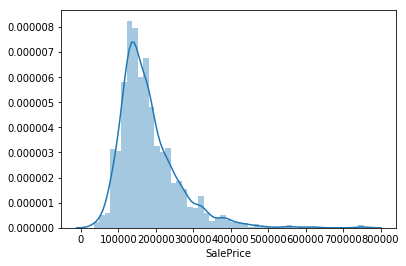

In [8]:
# Our SalesPrice is skewed right (check plot below). I'm logtransforming it. 
ax = sns.distplot(train_labels)

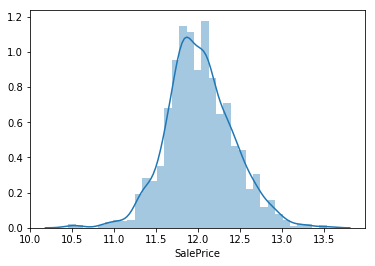

In [9]:
train_labels = np.log(train_labels)
ax = sns.distplot(train_labels)

In [10]:
numeric_features = features.loc[:,['LotFrontage', 'LotArea', 'GrLivArea', 'TotalSF']]
numeric_features_standardized = (numeric_features - numeric_features.mean())/numeric_features.std()

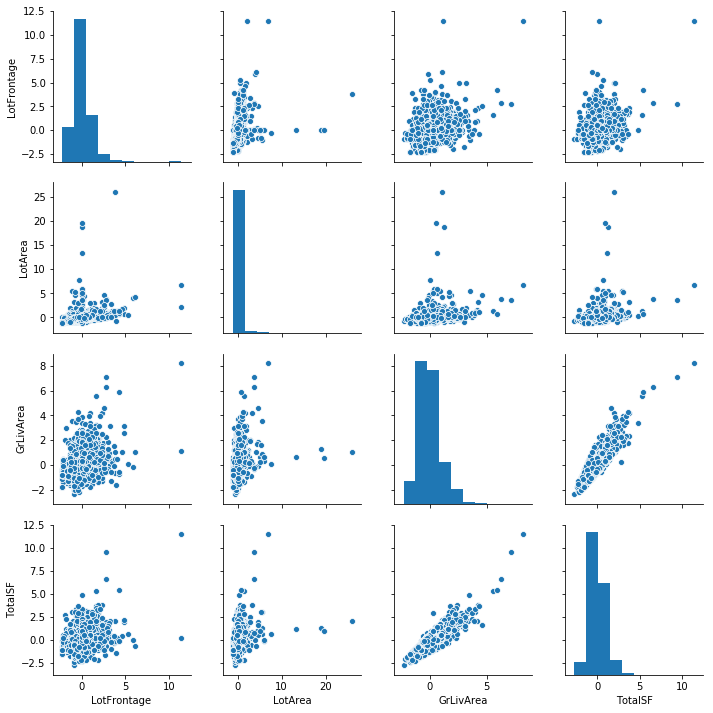

In [11]:
ax = sns.pairplot(numeric_features_standardized)

In [13]:
# Getting Dummies from Condition1 and Condition2
conditions = set([x for x in features['Condition1']] + [x for x in features['Condition2']])
dummies = pd.DataFrame(data=np.zeros((len(features.index), len(conditions))),
                       index=features.index, columns=conditions)
for i, cond in enumerate(zip(features['Condition1'], features['Condition2'])):
    dummies.ix[i, cond] = 1
features = pd.concat([features, dummies.add_prefix('Condition_')], axis=1)
features.drop(['Condition1', 'Condition2'], axis=1, inplace=True)

# Getting Dummies from Exterior1st and Exterior2nd
exteriors = set([x for x in features['Exterior1st']] + [x for x in features['Exterior2nd']])
dummies = pd.DataFrame(data=np.zeros((len(features.index), len(exteriors))),
                       index=features.index, columns=exteriors)
for i, ext in enumerate(zip(features['Exterior1st'], features['Exterior2nd'])):
    dummies.ix[i, ext] = 1
features = pd.concat([features, dummies.add_prefix('Exterior_')], axis=1)
features.drop(['Exterior1st', 'Exterior2nd', 'Exterior_nan'], axis=1, inplace=True)

# Getting Dummies from all other categorical vars
for col in features.dtypes[features.dtypes == 'object'].index:
    for_dummy = features.pop(col)
    features = pd.concat([features, pd.get_dummies(for_dummy, prefix=col)], axis=1)

In [14]:
### Copying features
features_standardized = features.copy()

### Replacing numeric features by standardized values
features_standardized.update(numeric_features_standardized)

In [15]:
### Splitting features
train_features = features.loc['train'].drop('Id', axis=1).select_dtypes(include=[np.number]).values
test_features = features.loc['test'].drop('Id', axis=1).select_dtypes(include=[np.number]).values

### Splitting standardized features
train_features_st = features_standardized.loc['train'].drop('Id', axis=1).select_dtypes(include=[np.number]).values
test_features_st = features_standardized.loc['test'].drop('Id', axis=1).select_dtypes(include=[np.number]).values

In [16]:
### Shuffling train sets
train_features_st, train_features, train_labels = shuffle(train_features_st, train_features, train_labels, random_state = 5)

In [17]:
### Splitting
x_train, x_test, y_train, y_test = train_test_split(train_features, train_labels, test_size=0.1, random_state=200)
x_train_st, x_test_st, y_train_st, y_test_st = train_test_split(train_features_st, train_labels, test_size=0.1, random_state=200)

In [18]:
ENSTest = linear_model.ElasticNetCV(alphas=[0.0001, 0.0005, 0.001, 0.01, 0.1, 1, 10], l1_ratio=[.01, .1, .5, .9, .99], max_iter=5000).fit(x_train_st, y_train_st)
train_test(ENSTest, x_train_st, x_test_st, y_train_st, y_test_st)

ElasticNetCV(alphas=[0.0001, 0.0005, 0.001, 0.01, 0.1, 1, 10], copy_X=True,
       cv=None, eps=0.001, fit_intercept=True,
       l1_ratio=[0.01, 0.1, 0.5, 0.9, 0.99], max_iter=5000, n_alphas=100,
       n_jobs=1, normalize=False, positive=False, precompute='auto',
       random_state=None, selection='cyclic', tol=0.0001, verbose=0)
R2: 0.9009283329651949
RMSE: 0.1192141838284098
Test
R2: 0.8967298984840515
RMSE: 0.11097045003313134


In [19]:
scores = cross_val_score(ENSTest, train_features_st, train_labels, cv=5)
print("Accuracy: %0.2f (+/- %0.2f)" % (scores.mean(), scores.std() * 2))

Accuracy: 0.88 (+/- 0.10)


In [20]:
GBest = ensemble.GradientBoostingRegressor(n_estimators=3000, learning_rate=0.05, max_depth=3, max_features='sqrt',
                                               min_samples_leaf=15, min_samples_split=10, loss='huber').fit(x_train, y_train)
train_test(GBest, x_train, x_test, y_train, y_test)

GradientBoostingRegressor(alpha=0.9, criterion='friedman_mse', init=None,
             learning_rate=0.05, loss='huber', max_depth=3,
             max_features='sqrt', max_leaf_nodes=None,
             min_impurity_decrease=0.0, min_impurity_split=None,
             min_samples_leaf=15, min_samples_split=10,
             min_weight_fraction_leaf=0.0, n_estimators=3000,
             presort='auto', random_state=None, subsample=1.0, verbose=0,
             warm_start=False)
R2: 0.962380179090389
RMSE: 0.07540448209521199
Test
R2: 0.9013310721758181
RMSE: 0.10733961029628124


In [21]:
# Average R2 score and standart deviation of 5-fold cross-validation
scores = cross_val_score(GBest, train_features_st, train_labels, cv=5)
print("Accuracy: %0.2f (+/- %0.2f)" % (scores.mean(), scores.std() * 2))

Accuracy: 0.90 (+/- 0.04)


In [22]:
# Retraining models
GB_model = GBest.fit(train_features, train_labels)
ENST_model = ENSTest.fit(train_features_st, train_labels)
## Getting our SalePrice estimation
Final_labels = (np.exp(GB_model.predict(test_features)) + np.exp(ENST_model.predict(test_features_st))) / 2
## Saving to CSV
pd.DataFrame({'Id': test.Id, 'SalePrice': Final_labels}).to_csv('2017-02-28.csv', index =False)